In [14]:
## We read in any packages required
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plot
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
import plotly.express as px
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, make_scorer, RocCurveDisplay, roc_auc_score, brier_score_loss


In [15]:
# We read in the data and remove the first two unwanted columns
df = pd.read_csv('df_final.txt',sep=',')
df.drop(df.columns[[0, 1]], axis=1, inplace=True)

In [17]:
# We calculate the correlation values between our features etc
# We then create a dataframe with our feature names as a column
# We then extract the correlations with our target varuable and add them as a new column
df_corr = df.corr()
columns = df.columns
correlations = pd.DataFrame(columns)
Targets = df_corr.Target
Targets = list(Targets)
correlations['Values'] = Targets
correlations = correlations.sort_values(by=['Values'], ascending=False)
correlations.head(5)

## We are going to have a look at some of our important features

In [21]:
# Here we create our dataframe and seperate the target variable
# We also drop any unwanted columns
# We split the data and then train a randomforest
X = df.drop(['Target','DeceasedMonth','PersonKey'],axis=1)
y = df.Target
features = X.columns
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [22]:
# We create a dataframe with our feature names and the respective values
# We then sort the features based on the feature importances
feats = pd.DataFrame(features)
feats['Values'] = rf.feature_importances_
cols = ['Feats','Values']
feats.columns = cols
feats = feats.sort_values(by=['Values'], ascending=False)

## Here we will fit a standard logistic regression for a base model

In [24]:
# We define 5 rounds of CV and our logistic regression
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
logreg = LogisticRegression(max_iter=10000)

In [25]:
def base(X,y):
    
    # We set some empty lists for later use
    scores = []
    accs = []
    pres = []
    # We create a for loop through train and test indicies
    for train_index, test_index in skf.split(X, y):
        # Our train and tet sets are then created from our indicies
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # We now need to undersample our dataset due imbalances
        # We count the number of deaths and living patients in the training set
        # We increase the class_count by 1.5 for overfitting purposes
        # We split our train into deats and alive patients
        # We then sample the majority class with our minority class count
        X_train['Target'] = y_train
        class_count_0, class_count_1 = y_train.value_counts()
        class_count_1 = int(class_count_1*1.5)
        X_train_zero = X_train[X_train['Target'] == 0]
        X_train_one = X_train[X_train['Target'] == 1]
        X_train_0_under = X_train_zero.sample(class_count_1)
        X_train = pd.concat([X_train_0_under, X_train_one], axis=0)
        X_train = shuffle(X_train)
        y_train = X_train['Target']
        X_train = X_train.drop(['Target'], axis = 1)

        # Here we fit our standardscaler and transform both our train and test sets
        scaler = StandardScaler()
        df = X_test
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        # We then fit our logistic regression and create our predictions
        logreg = LogisticRegression(max_iter=10000)
        logreg.fit(X_train,y_train)
        y_test_pred = logreg.predict(X_test)
        # We calculate AUC based on our preds and test set
        auc1 = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
        scores.append(auc1)
    
        # Here we create another set of predictions for our classification report
        y_pred = logreg.predict(X_test)
        # We calculate a number of metrics to assess model performance
        classs = classification_report(y_test, y_pred)
        print(classs)

        specificity_score=make_scorer(recall_score, pos_label=0)

        spec = recall_score(y_test,y_pred,pos_label= 0)

        conf_mat = confusion_matrix(y_test, y_pred, normalize= 'true')
        ConfusionMatrixDisplay(conf_mat).plot()
        plot.show()


    return scores,accs,logreg,y_test,classs


              precision    recall  f1-score   support

           0       1.00      0.91      0.95    160203
           1       0.10      0.88      0.18      1742

    accuracy                           0.91    161945
   macro avg       0.55      0.90      0.56    161945
weighted avg       0.99      0.91      0.94    161945



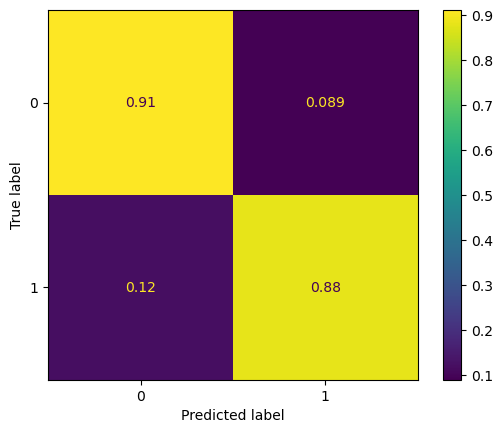

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    160203
           1       0.10      0.90      0.17      1742

    accuracy                           0.91    161945
   macro avg       0.55      0.90      0.56    161945
weighted avg       0.99      0.91      0.94    161945



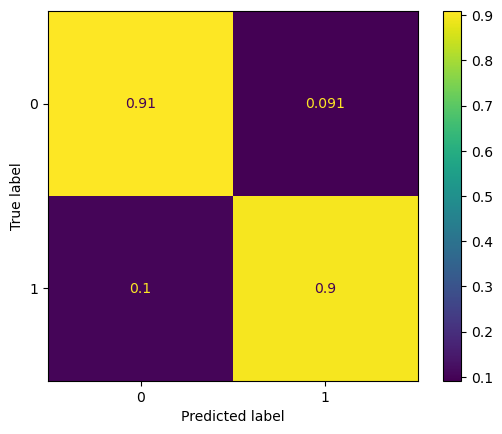

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    160203
           1       0.10      0.89      0.17      1742

    accuracy                           0.91    161945
   macro avg       0.55      0.90      0.56    161945
weighted avg       0.99      0.91      0.94    161945



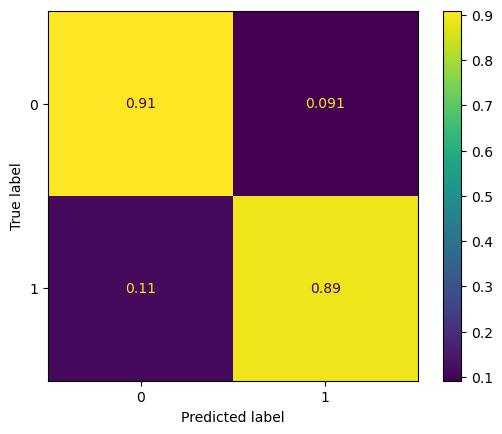

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    160202
           1       0.10      0.87      0.18      1742

    accuracy                           0.91    161944
   macro avg       0.55      0.89      0.57    161944
weighted avg       0.99      0.91      0.95    161944



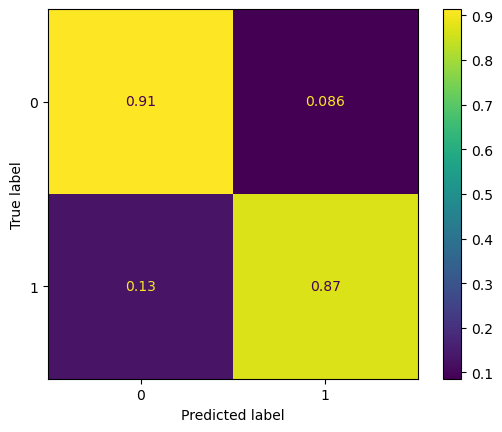

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    160202
           1       0.10      0.89      0.17      1742

    accuracy                           0.91    161944
   macro avg       0.55      0.90      0.56    161944
weighted avg       0.99      0.91      0.94    161944



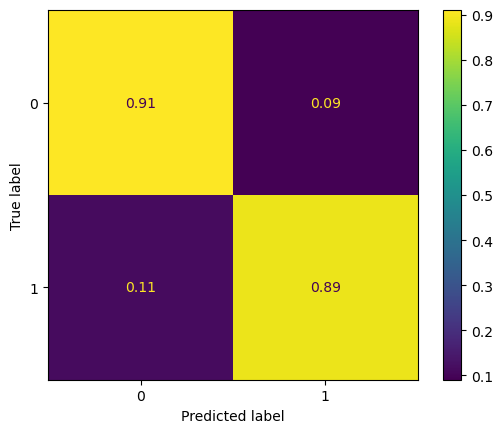

In [26]:
res = base(X,y)

## We now fit a Random forest and gradient boosted model for comparison

In [37]:
def rand(X,y):
    rf_scores = []
    clf_scores = []
    for train_index, test_index in skf.split(X, y):
        # Our train and tet sets are then created from our indicies
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # We now need to undersample our dataset due imbalances
        # We count the number of deaths and living patients in the training set
        # We increase the class_count by 1.5 for overfitting purposes
        # We split our train into deats and alive patients
        # We then sample the majority class with our minority class count
        X_train['Target'] = y_train
        class_count_0, class_count_1 = y_train.value_counts()
        class_count_1 = int(class_count_1*2)
        X_train_zero = X_train[X_train['Target'] == 0]
        X_train_one = X_train[X_train['Target'] == 1]
        X_train_0_under = X_train_zero.sample(class_count_1)
        X_train = pd.concat([X_train_0_under, X_train_one], axis=0)
        y_train = X_train['Target']
        X_train = X_train.drop(['Target'], axis = 1)

        # Here we fit our standardscaler and transform both our train and test sets
        scaler = StandardScaler()
        X_test = X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        # We then fit our random forest and create our predictions
        rf = RandomForestClassifier(class_weight='balanced')
        rf.fit(X_train,y_train)
        rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
        rf_probs = rf.predict_proba(X_test)[:, 1]
        rf_scores.append(rf_auc)

        # We then fit our gradient boosted model and create our predictions
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
        clf.fit(X_train,y_train)
        clf_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        clf_probs = clf.predict_proba(X_test)[:, 1]
        clf_scores.append(clf_auc)

        y_pred = rf.predict(X_test)

        # We calculate a number of metrics to assess model performance
        classs = classification_report(y_test, y_pred)
        print(classs)

        specificity_score=make_scorer(recall_score, pos_label=0)

        spec = recall_score(y_test,y_pred,pos_label= 0)

        y_pred_new_threshold = (rf.predict_proba(X_test)[:, 1] >= 0.6).astype(int) 

        fpr_, tpr_, thresholds_ = roc_curve(y_test, y_pred_new_threshold) 
        print('Area Under the ROC Curve for threshold 0.9:', roc_auc_score(y_test, y_pred_new_threshold)) 

        conf_mat = confusion_matrix(y_test, y_pred_new_threshold, normalize= 'true')
        ConfusionMatrixDisplay(conf_mat).plot()
        plot.show()



    return np.mean(rf_scores),np.mean(clf_scores)


              precision    recall  f1-score   support

           0       1.00      0.91      0.95    160203
           1       0.10      0.92      0.17      1742

    accuracy                           0.91    161945
   macro avg       0.55      0.91      0.56    161945
weighted avg       0.99      0.91      0.94    161945

Area Under the ROC Curve for threshold 0.9: 0.9005997990652116


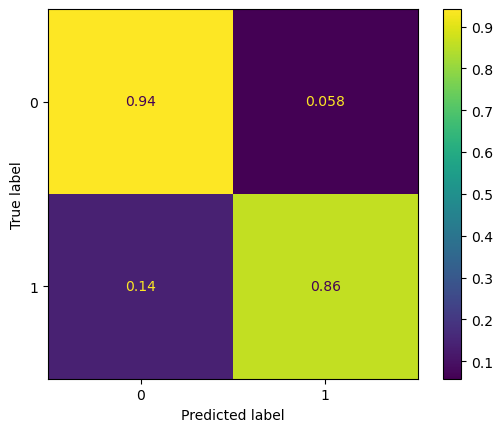

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    160203
           1       0.09      0.91      0.17      1742

    accuracy                           0.90    161945
   macro avg       0.55      0.91      0.56    161945
weighted avg       0.99      0.90      0.94    161945

Area Under the ROC Curve for threshold 0.9: 0.9033884789241963


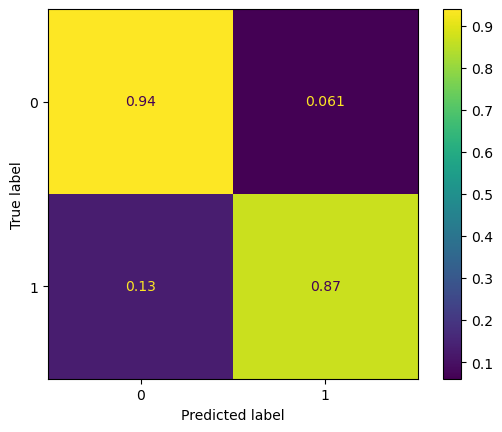

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    160203
           1       0.09      0.91      0.17      1742

    accuracy                           0.90    161945
   macro avg       0.55      0.91      0.56    161945
weighted avg       0.99      0.90      0.94    161945

Area Under the ROC Curve for threshold 0.9: 0.8986247270818777


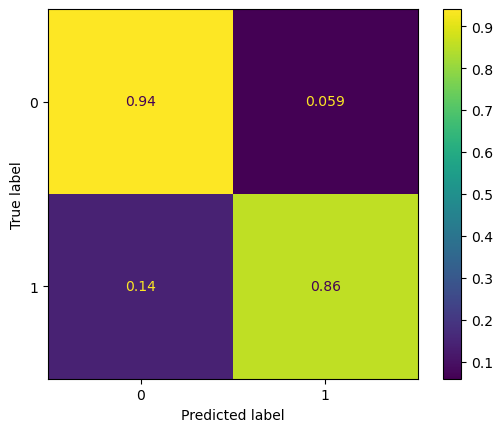

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    160202
           1       0.09      0.90      0.17      1742

    accuracy                           0.90    161944
   macro avg       0.55      0.90      0.56    161944
weighted avg       0.99      0.90      0.94    161944

Area Under the ROC Curve for threshold 0.9: 0.8949771342784212


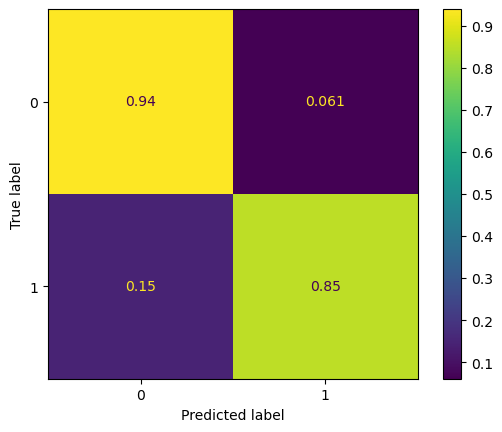

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    160202
           1       0.09      0.92      0.16      1742

    accuracy                           0.89    161944
   macro avg       0.54      0.91      0.55    161944
weighted avg       0.99      0.89      0.94    161944

Area Under the ROC Curve for threshold 0.9: 0.901297290844247


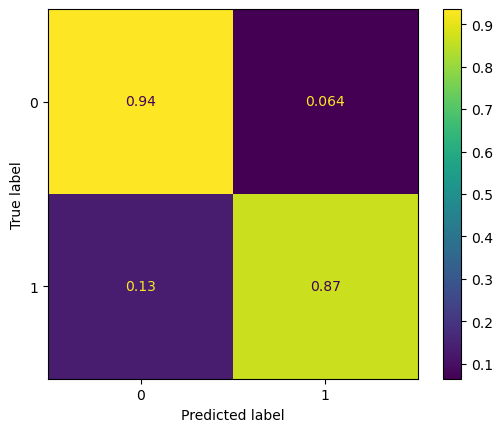

In [38]:
res = rand(X,y)